# Логистическая регрессия и случайный лес, домашнее задание

## Обзор

В задании вам предстоит на простом примере познакомиться с базовыми инструментами построения логистической регрессии:
* визуализация
* разбиение данных на обучающую и тестовую выборки
* преобразование переменных
* отбор переменных
* $L1$ и $L2$ регуляризации
* построение итоговой модели и валидация

Далее вы построите случайный лес и сравните два класса моделей.

Все это будет на сгенерированных данных.
Примеры многих функций уже есть в коде, остальное можно посмотреть в официальных документациях или просто поискать в интернете примеры применения.

Оценка будет выставляться с учетом первых трех заданий, третье опционально

## Сгенерируем данные

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score as ra
import pandas as pd

X, y = make_classification(n_samples=7000, n_features=20, n_informative=5, n_redundant=2,
                           n_repeated=0, scale=None, shift=None, shuffle=False, class_sep=0.5,
                           random_state=40)

In [ ]:
dataframe = pd.DataFrame(X)
dataframe["target"] = y
dataframe

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
0,-46.277038,-169.211895,89.414557,-78.903131,-26.731402,141.032268,39.389168,-18.777040,-1.738580,18.501089,...,46.730170,-9.968648,36.788975,-35.089049,-128.232041,-63.039599,15.020217,108.425941,-8.573379,0
1,-222.864210,57.760474,-94.073597,-63.805919,-89.137473,49.482030,3.688442,8.395622,-1.099120,-20.040514,...,-11.053576,-39.982496,14.641007,3.610509,-93.756549,-35.361443,-27.793638,-101.637520,-14.497597,0
2,-67.434625,99.329169,-28.685001,33.533627,-11.706835,-34.293447,-30.067031,12.976128,1.401020,-8.177246,...,-41.827029,78.336703,9.791404,3.728595,77.153235,-21.595443,95.528189,72.298890,-20.124996,0
3,-184.544177,-70.074029,74.729164,30.015865,-45.854628,163.127878,-34.003829,-28.428485,6.392218,6.796828,...,14.219447,-27.856380,21.811676,40.837319,-38.775834,-74.950320,49.728842,-52.722803,51.204517,0
4,-129.439481,4.541231,-111.525376,-75.144675,-13.596824,-39.504761,58.366137,2.048067,-4.038327,6.228075,...,4.076987,77.082123,70.087053,-23.321515,-18.700076,-21.073950,91.634220,0.615705,2.390110,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,88.868087,164.890551,7.366240,-5.329569,36.309102,-155.232981,-12.571391,26.732010,-9.950442,-21.893563,...,-112.750388,3.478952,35.153998,-47.583501,-22.447155,-13.696624,-31.622276,-97.902748,-10.221870,1
6996,159.312148,0.843791,3.547991,-87.800228,-119.315029,87.748377,-18.146482,8.275145,-2.621984,-1.338543,...,-66.125538,-22.028782,13.430107,53.911974,-120.740478,-68.011038,-7.509589,-7.358195,-41.037884,1
6997,26.181180,-69.885187,214.899112,5.673370,22.036256,92.810374,-26.057112,3.164289,-3.903016,-6.527211,...,-84.422284,27.489222,23.461585,43.747331,-56.071808,10.792691,64.933763,-40.145753,-9.730125,1
6998,219.710428,-16.934557,-66.067832,27.331000,-143.921725,130.984179,-65.106099,14.469519,-3.369488,2.015194,...,-45.210756,-45.200309,-23.814240,-155.220511,-23.718266,17.254732,-42.915147,4.465570,-42.875317,1


Разбивка на train и test нужна для того, чтобы оставить часть данных нетронутой для проверки

Модель мы будем применять на данных, которые еще не видели, и разбивка позволяет нам хоть немного имитировать этот процесс

Если хотим использовать методы, требующие ручного подбора параметров (например, коэффициента регуляризации), можно выделить еще третий вид выборки — валидационную или validation. Подбор параметров традиционно выглядит так:
1. задаем параметр;
2. обучаем модель на train;
3. смотрим на качество предсказания на validation;
4. снова задаем параметр, возвращаемся к п.2;
5. ищем максимум качества на валидации;
6. выбираем параметры, которые лучше всего себя показали на validation, обучаем еще раз модель, проверяем итоги на test.

Если ручных параметров нет, можно делить выборку на 2 части — train, test

Выборка бьется последовательным применением train_test_split

Стандартные пропорции: 70:30 в случае с train/test, 60:20:20 в случае с train/val/test

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)

## Можно визуализировать зависимости, посмотреть на характер данных

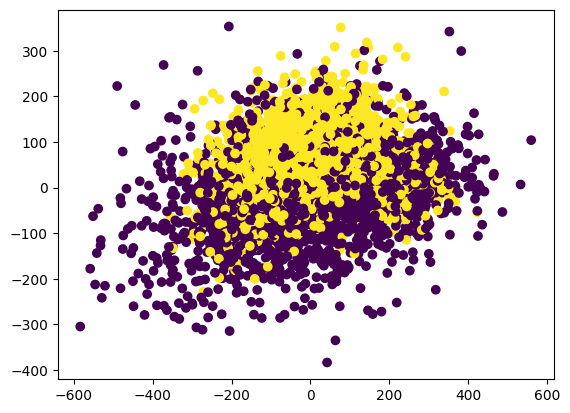

In [ ]:
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain)
plt.show()

Первично анализировать признаки удобно с помощью woe_line.

Функция делит наблюдения на группы по $X$, для каждой группы считает WoE, и откладывает эти значения на графике.

Можно встретить определение WoE, отличающееся знаком, на анализ и выводы это не влияет

# Анализ данных

## Подготовка

## Задание 1

Написать функцию woe_line:

1. разбить наблюдения на n_buckets групп по $X$
2. в каждой группе по y отложить WoE, по x медианное значение $X$
3. вывести полученный график
4. вывести ROC AUC признака (sklearn.metrics.roc_auc_score)
5. Опционально. Рассчитать доверительный интервал для bad rate (bad rate - доля наблюдений с целевой переменной =1 от всех наблюдений в группе)
6. Опционально. Нанести на график линейное приближение любым способом

График позволит проверить линейность зависимости, силу переменной, опционально проверить распределение

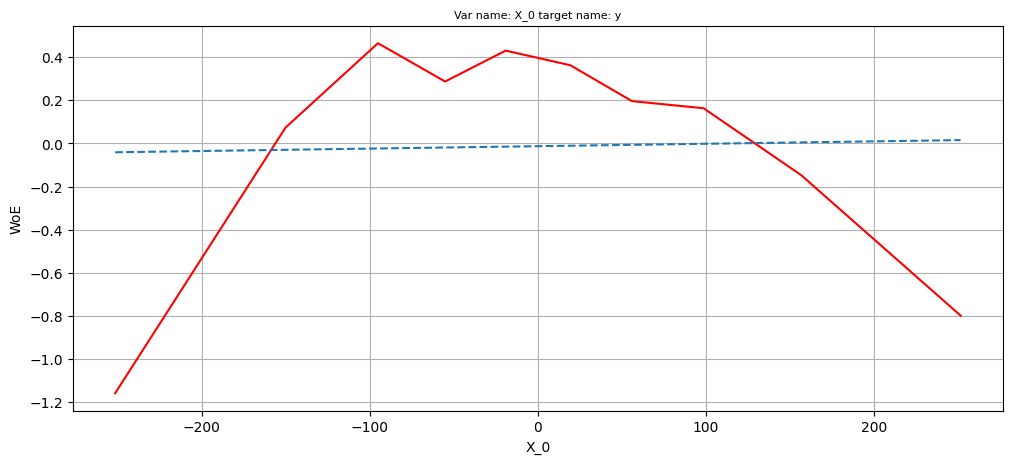

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

def woe_line(X,         # 1-d array with independent feature
             y,         # 1-d array with target feature
             n_buckets, # number of buckets to plot
             var_nm,    # optional, var_name to show above the plot
             target_nm, # optional, target_name to show above the plot
             plot_hist  # optional, if True — histogram of X is displayed
            ):
    df = pd.DataFrame(X)
    df["target"] = y
    df = df.sort_values(0, axis = 0)
    X_ = df[0]
    y_ = df["target"]
    buckets = []
    step = X_.shape[0]/n_buckets
    for i in range(n_buckets):
      buckets.append((X_[int(step*i):int(step*(i+1))], y_[int(step*i//1):int(step*(i+1)//1)]))
    xs = []
    ys = []
    plt.figure(figsize = (12, 5))
    for bucket in buckets:
      X_b, y_b = bucket
      Woe = np.log(list(y_b).count(1)/list(y_b).count(0))
      xs.append(np.median(X_b))
      ys.append(Woe)
    plt.plot(xs, ys, color = "r")
    if var_nm is not None:
      plt.xlabel(var_nm)
    if target_nm is not None:
      plt.ylabel("WoE")
    plt.title("Var name: "+str(var_nm)+ " target name: "+str(target_nm), size = 8)
    lr = LinearRegression()
    lr.fit(np.array([xs]), np.array([ys]))
    z = np.polyfit(xs, ys, 1)
    p = np.poly1d(z)
    plt.plot(xs, p(xs), linestyle="--")
    plt.grid (True)




woe_line(Xtrain[:, 0], ytrain, n_buckets=10, plot_hist=False,                var_nm = 'X_0', target_nm = 'y')

На примере функция дополнительно отображает $R^2$ — меру линейности зависимости, а также линию, показывающую линейное приближение

## Анализ каждой переменной

В ячейке ниже пример функции и результата ее выполнения на других данных. Сам график может быть отрисован чуть иначе или в другой библиотеке, главное — сохранить суть

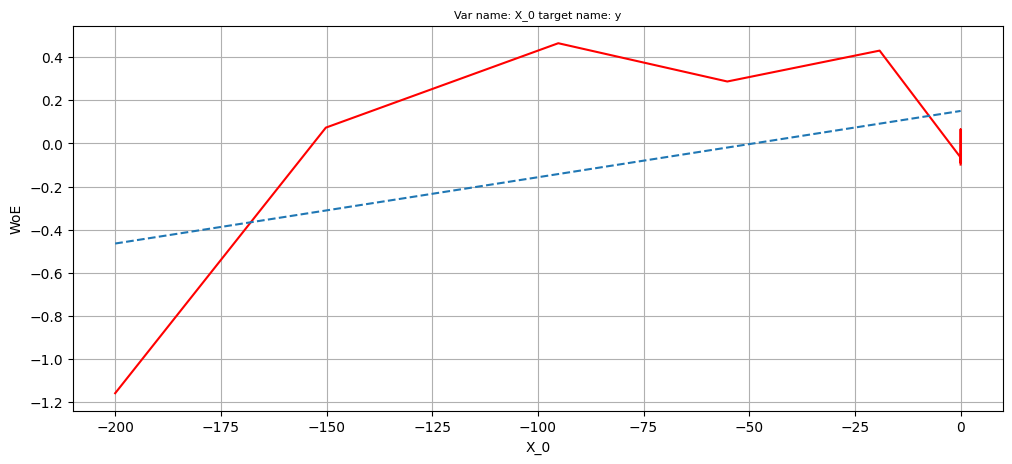

In [ ]:
res = woe_line(np.clip(Xtrain[:, 0], -200, 0), ytrain, n_buckets=10, plot_hist=False,
               var_nm = 'X_0', target_nm = 'y')

Видно, что переменная разделяет целевую переменную примерно до значения 0, дальше кривая выходит на плато. Можно ограничить этот хвост, чтобы не закладывать разделение в модель

Можно сразу в woe_line передавать преобразованную переменную, важно потом при проверках модели на test не забыть сделать то же преобразование

Для борьбы с выбросами можно также ограничивать длинные хвосты распределения. Особенно это полезно в реальном применении модели, чтобы ограничить влияние одной переменной на предсказание всей модели

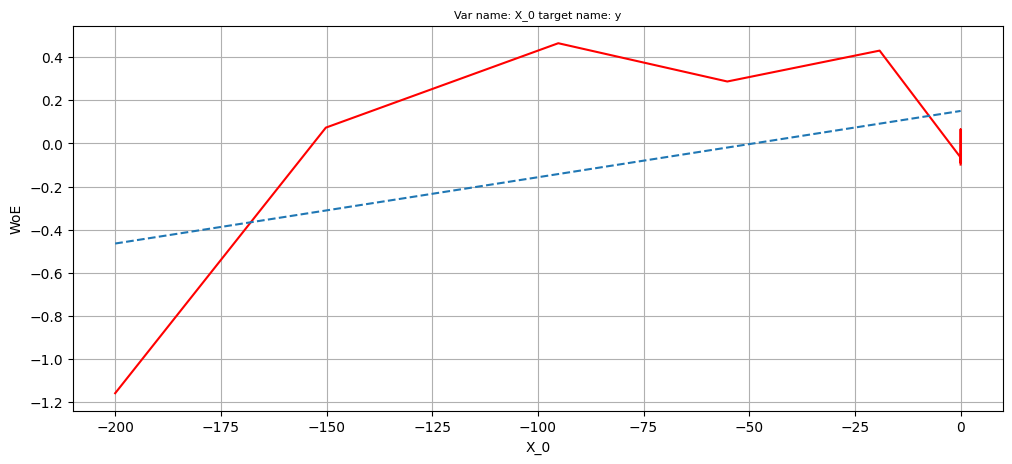

In [ ]:
res = woe_line(np.clip(Xtrain[:, 0], -200, 0), ytrain, n_buckets=10, plot_hist=False,
               var_nm = 'X_0', target_nm = 'y')

При преобразовании переменных важно соблюдать баланс:

1. переменная должна стать линейной,
2. не стоит доводить до идеальной линейности в ущерб разделяющей силы (ROC AUC),
3. в работе с реальными данными стоит обращать внимание на физический смысл переменных. Например, в случае с размерными переменными (рубли, метры), часто помогает взятие корня или логарифма, а еще лучше приводить их к безразмерным величинам нормировкой.

## Задание 2

1. проверить каждую переменную на woe_line,
2. каждую полезную переменную линеаризовать (для каждой переменной нужны графики ДО и ПОСЛЕ),
3. ненужные переменные (слабые по ROC AUC, немонотонные) исключить из модели,
4. на отобранных и линеаризованных переменных построить модель, проверить результат на test по ROC AUC.

Подробно про обучение моделей можно почитать в официальной документации, там же есть примеры использования

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Построение логистической регрессии

In [ ]:
X = dataframe.drop("target", axis = 1)
y = dataframe["target"]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
pd.Series(y).value_counts()

0    3505
1    3495
Name: target, dtype: int64

Как видно, классы сбалансированы.

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(Xtrain, ytrain)

from sklearn.metrics import accuracy_score as acc, recall_score as r, precision_score as p, roc_auc_score as ra
pred = lr.predict(Xtest)
print("Accuracy:", acc(ytest, pred))
print("Recall:", r(ytest, pred))
print("Precision:", p(ytest, pred))
print("Roc_auc:", ra(ytest, pred))


Accuracy: 0.7409523809523809
Recall: 0.7639024390243903
Precision: 0.7216589861751153
Roc_auc: 0.7414861032331254


Качество отстойное

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LogisticRegression(), param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100, 1000]},
  {'penalty': ['l1', 'l2']},
  #{'solver': ['lbfgs', 'liblinear', 'newton-cg']}
  ],
  scoring = "roc_auc")
grid.fit(Xtrain, ytrain)


NameError: ignored

In [ ]:
grid.best_estimator_

LogisticRegression(C=0.1)

In [ ]:
pred_g = grid.predict(Xtest)
print("Accuracy:", acc(ytest, pred_g))
print("Recall:", r(ytest, pred_g))
print("Precision:", p(ytest, pred_g))
print("Roc_auc:", ra(ytest, pred_g))

Accuracy: 0.7414285714285714
Recall: 0.7648780487804878
Precision: 0.7219152854511971
Roc_auc: 0.7419739081111741


При подборе гиперпараметров ситуация сильно не изменилась, логистическая регрессия не очень хорошо решает задачу.

## Задание 3

В этом задании предлагается сравнить алгоритм Random Forest с логистической регрессией. Обучите две модели, подобрав гиперпараметры на отделенной от трейна валидационной выборке.

 - на всех признаках из изначального датасета (на сырых данных)
 - на признаках, на которых вы строили логрег (после удаления неинформативных признаков и линеаризации остальных)

Насколько сильнее (или наоборот слабее) показали себя "деревянные модели" по сравнению с линейными? Помогла ли предобработка переменных улучшить качество случайного леса?

# Построение случайного леса

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(Xtrain, ytrain)

pred_rf = rf.predict(Xtest)
print("Accuracy:", acc(ytest, pred_rf))
print("Recall:", r(ytest, pred_rf))
print("Precision:", p(ytest, pred_rf))
print("Roc_auc:", ra(ytest, pred_rf))

Accuracy: 0.8580952380952381
Recall: 0.8692682926829268
Precision: 0.8445497630331753
Roc_auc: 0.8583550765740215


Дефолтный лес неплохо решает задачу, заметно лучше, чем логистическая регрессия. Давайте теперь поиграемся с гиперпараметрами, попытаемся улучшить качество модели.

In [ ]:
gridrf = GridSearchCV(RandomForestClassifier(), param_grid = [
  {'n_estimators': [1000]},
  {"criterion": ['gini', 'entropy', 'log_loss']},
  {"max_depth": [1, 2, 3, 5, 10, 20]},
  {"min_samples_split": [1, 2, 4, 10]},
  {"max_features":['sqrt', 'log2', None]}
  ], scoring = "roc_auc")
gridrf.fit(Xtrain, ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 85.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'n_estimators': [1000]},
                         {'criterion': ['gini', 'entropy', 'log_loss']},
                         {'max_depth': [1, 2, 3, 5, 10, 20]},
                         {'min_samples_split': [1, 2, 4, 10]},
                         {'max_features': ['sqrt', 'log2', None]}],
             scoring='roc_auc')

In [ ]:
pred_grf = gridrf.predict(Xtest)
print("Accuracy:", acc(ytest, pred_grf))
print("Recall:", r(ytest, pred_grf))
print("Precision:", p(ytest, pred_grf))
print("Roc_auc:", ra(ytest, pred_grf))

Accuracy: 0.8571428571428571
Recall: 0.8653658536585366
Precision: 0.8455672068636797
Roc_auc: 0.8573340896199659


Качество значительно не изменилось.

# Дополнительно

Задание 4, опционально

В функции генерации датасета указано $n\_redundant=2$. Это значит, что две переменные получены линейной комбинацией информативных переменных.

Предыдущий анализ никак не исключает появления всех переменных в модели, для этого можно воспользоваться методами отбора признаков.

1. нужно разбить исходную выборку на 3 части: train, val, test, и попробовать подобрать коэффициент $L1$-регуляризации на валидационной выборке. Это должно убрать лишние переменные из модели и повысить таким образом ее стабильность.

Регуляризации в логистической регрессии сильно зависит от стандартного отклонения признака, поэтому стоит воспользоваться нормировкой: sklearn.preprocessing.StandardScaler

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

С нормировкой действуют те же правила: обучается она на train, применяется на val, test

2. подобрать коэффициент $L2$-регуляризации, чтобы избежать слишком больших коэффициентов и улучшить качество на val, test. На этом шаге использовать только те переменные, которые отобраны после п.1

In [ ]:
# your code here